In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optimizers
import torchvision
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.utils.data
import torchsummary
from PIL import Image
from matplotlib import cm

In [2]:
outf = 'result_3_2-DCGAN'

In [ ]:
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error: 
    print(error)
    pass

In [3]:
workers=2
batch_size=50
nz=100
nch_g=128
nch_d=128
n_epoch=10
lr=0.0002
beta1=0.5


In [4]:
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
mnist_train =torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)

In [5]:
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [6]:
class Generator(nn.Module):
    """
    torch.nn.ConvTranspose2d(in_channels, out_channels, 
    kernel_size, stride=1, padding=0, 
    output_padding=0, groups=1, bias=True, 
    dilation=1, padding_mode='zeros')
    """
    def __init__(self, nz=100, nch_g=128, nch=1):
        super(Generator,self).__init__()
        self.layers=nn.ModuleDict({
            'layer0':nn.Sequential(
            nn.ConvTranspose2d(nz,nch_g*4,3,1,0),
            nn.BatchNorm2d(nch_g*4),
            nn.ReLU()),
            'layer1':nn.Sequential(
            nn.ConvTranspose2d(nch_g*4,nch_g*2,3,2,0),
            nn.BatchNorm2d(nch_g*2),
            nn.ReLU()),
            'layer2':nn.Sequential(
            nn.ConvTranspose2d(nch_g*2,nch_g,4,2,1),
            nn.BatchNorm2d(nch_g),
            nn.ReLU()),
            'layer3':nn.Sequential(
            nn.ConvTranspose2d(nch_g,nch,4,2,1),
            nn.Tanh())
        })
    
    def forward(self,z):
        for layer in self.layers.values():
            z=layer(z)
        return z
    

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nch=1, nch_d=128):
        """
        :param nch: 入力画像のチャネル数
        :param nch_d: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            ),  # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 7, 7) -> (B, nch_d*4, 3, 3)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                nn.Sigmoid()    # Sigmoid関数
            )    
            # (B, nch_d*4, 3, 3) -> (B, 1, 1, 1)
        })

    def forward(self, x):
    
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:          
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:      
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:   
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
gnet=Generator().to(device)
gnet.apply(weights_init)
torchsummary.summary(gnet, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,169,473
Trainable params: 2,169,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [10]:
dnet=Discriminator().to(device)
dnet.apply(weights_init)
torchsummary.summary(dnet, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,713,025
Trainable params: 1,713,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 6.53
Estimat

In [11]:
criterion=nn.BCELoss()

fixed_noise=torch.randn(batch_size,nz,1,1,device=device)

optimizerD=optimizers.Adam(dnet.parameters(),lr=lr,betas=(beta1,0.999),weight_decay=1e-5)
optimizerG=optimizers.Adam(gnet.parameters(),lr=lr,betas=(beta1,0.999),weight_decay=1e-5)


In [12]:
G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []


display_interval = 600


for epoch in range(n_epoch):
    for itr,data in enumerate(dataloader):
        real_img=data[0].to(device)

        sample_size=real_img.size(0)
        
        noise=torch.randn(sample_size,nz,1,1,device=device)
        
        #正解ラベル
        real_target=torch.full((sample_size,),1.,device=device)
        
        fake_target=torch.full((sample_size,),0.,device=device)
        
        dnet.zero_grad()
        
        out=dnet(real_img)
        err_d_real=criterion(out,real_target)
        
        D_x=out.mean().item()
        
        fake_img=gnet(noise)
        
        out=dnet(fake_img.detach())
        err_d_fake=criterion(out,fake_target)
        
        D_G_z1=out.mean().item()
        
        err_d=err_d_fake+err_d_real
        
        err_d.backward()
        
        optimizerD.step()
        
        
        gnet.zero_grad()
        
        out=dnet(fake_img)
        
        errG=criterion(out,real_target)
        
        errG.backward()
        
        D_G_z2=out.mean().item()
        
        optimizerG.step()
        
        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          err_d.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if epoch == 0 and itr == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_img, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(err_d.item())
        G_losses.append(errG.item())
        D_x_out.append(D_x)
        D_G_z1_out.append(D_G_z1)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = gnet(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)

    ############################
    # モデルの保存
    ############################
    if (epoch + 1) % 10 == 0:   # 10エポックごとにモデルを保存する
        torch.save(gnet.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
        torch.save(dnet.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/10][1/1200] Loss_D: 1.360 Loss_G: 2.754 D(x): 0.534 D(G(z)): 0.451/0.078
[1/10][601/1200] Loss_D: 0.377 Loss_G: 2.571 D(x): 0.744 D(G(z)): 0.031/0.109
[2/10][1/1200] Loss_D: 0.760 Loss_G: 3.603 D(x): 0.878 D(G(z)): 0.412/0.039
[2/10][601/1200] Loss_D: 0.457 Loss_G: 2.157 D(x): 0.850 D(G(z)): 0.218/0.144
[3/10][1/1200] Loss_D: 0.492 Loss_G: 2.817 D(x): 0.903 D(G(z)): 0.292/0.075
[3/10][601/1200] Loss_D: 1.039 Loss_G: 1.109 D(x): 0.482 D(G(z)): 0.057/0.432
[4/10][1/1200] Loss_D: 0.491 Loss_G: 1.970 D(x): 0.761 D(G(z)): 0.163/0.181
[4/10][601/1200] Loss_D: 0.784 Loss_G: 3.646 D(x): 0.951 D(G(z)): 0.455/0.035
[5/10][1/1200] Loss_D: 0.371 Loss_G: 3.533 D(x): 0.805 D(G(z)): 0.100/0.044
[5/10][601/1200] Loss_D: 0.501 Loss_G: 2.769 D(x): 0.746 D(G(z)): 0.136/0.092
[6/10][1/1200] Loss_D: 0.381 Loss_G: 3.096 D(x): 0.921 D(G(z)): 0.232/0.060
[6/10][601/1200] Loss_D: 0.385 Loss_G: 3.822 D(x): 0.923 D(G(z)): 0.243/0.027
[7/10][1/1200] Loss_D: 0.508 Loss_G: 4.526 D(x): 0.939 D(G(z)): 0.307/0.014


torch.Size([40, 100, 1, 1])
torch.Size([15, 100, 1, 1])


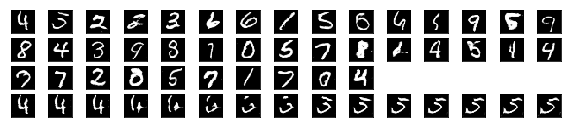

In [74]:
n_s=40
n_move=15


ims=[]

fig = plt.figure(figsize=(10, 3))

# 本物画像から生成画像
fixed_noise=torch.randn(n_s,nz,1,1,device=device)
fake_image = gnet(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
x = fake_image.to('cpu').detach().numpy().copy()
for i in range(n_s):
    ax = fig.add_subplot(6, 15, i+1, xticks=[], yticks=[])
    ax.imshow(x[i][0], 'gray')
print(fixed_noise.shape)
z1to0_noise = torch.cat([fixed_noise[1] * (i * 0.1) + fixed_noise[0] * ((9 - i) * 0.1) for i in range(n_move)]).reshape(n_move,100,1,1)
print(z1to0_noise .shape)
fake_image = gnet(z1to0_noise )  # 1エポック終了ごとに確認用の生成画像を生成する
x = fake_image.to('cpu').detach().numpy().copy()
for i in range(n_move):
    ax = fig.add_subplot(6, 15, i+46, xticks=[], yticks=[])
    imm=Image.fromarray(np.uint8(cm.gist_earth(x[i][0])*255))
    ims.append(imm)
    ax.imshow(x[i][0], 'gray')

In [68]:
ims[0].save('dcgan.gif' , save_all = True , append_images = ims[1:] , duration = 400 , loop = 0)